# Small CNN for traffic sign recognition as template for  assignment
## Christian Igel, 2020

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

In [69]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import json
import numpy as np
import random
import pathlib
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print("TensorFlow version:", tf.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version: 2.1.0


In [70]:
Linux = False

if Linux:
    # Clear any logs from previous runs (Linux).
    !mkdir -p /tmp/logs
    !rm -rf /tmp/logs/lsda
else:
    # NB: The two lines below can only be executed on Windows.
    !del /S /Q .\logs\*
    !for /d %i in (.\logs\*.*) do @rmdir /s /q "%i"

In [50]:
@tf.function
def my_func():
  node1 = tf.constant(3.0, name="a")
  #print("Hallo", node1)
  node2 = tf.constant(4.0, name="b")
  return tf.add(node1, node2, name="sum")

# Set up logging.
writer = tf.summary.create_file_writer("logs/func/trial1")

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
# Call only one tf.function when tracing.
z = my_func()
#z = first_TF_function()
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0)

In [51]:
# Execute the line below on Linux.
if Linux:
    %tensorboard --logdir logs/func

# If on Windows, run the following in a CMD prompt:
"""
conda activate tensorflow_gpu
tensorboard --logdir=logs/func
"""
# Then enter this in a web browser: "http://localhost:6006/"

'\nconda activate tensorflow_gpu\ntensorboard --logdir=logs/func\n'

You  can call 

`tensorboard --logdir=logs/func`

outside the notebook, giving you a link to view the graph (and more) in a browser (via opening, e.g., `http://localhost:6006`).
You may have to locate the `tensorboard` executable first. 

Download the data:

In [52]:
data_root="."
tf.keras.utils.get_file("GTSRB.zip",
                        "https://sid.erda.dk/share_redirect/EB0rrpZwuI",
                        cache_dir=data_root,
                        extract=True)


'.\\datasets\\GTSRB.zip'

The images are stored in subdirectories. The names of the subdirectories encode the class labels. 

In [53]:
# Determine the number of training and test images
n_train = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/train/*/*")))
n_test = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/test/*/*")))

print("Number of training images:", n_train)
print("Number of test images:" ,n_test)

Number of training images: 39209
Number of test images: 12630


Some basic constants: 

In [54]:
no_classes = 43  # There are 43 different signs
no_channels = 3  # We are dealing with color images

# All images are initially resized to img_height x img_width
img_height  = 32  
img_width   = 32
# During training and testing the  images are cropped to img_height_crop x img_width_crop
img_height_crop = 28  
img_width_crop  = 28

batch_size = 128
steps_per_epoch = n_train // batch_size  # How many batches are there in each epoch?

Helper functions for extracting the label information from the paths to the images and loading and preprocessing the images:

In [55]:
# Extract the label from the file path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.strings.to_number(parts[-2], tf.int32)

# Load image, convert it to floats, and resize it
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=no_channels)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

# Given the path and filename of an image, create the label and the input image
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Create data sets based on the files:

In [56]:
# Tell dataset the lists of files containing the trainig and test images, respectively
list_ds_train = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/train/*/*")
list_ds_test  = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/test/*/*", shuffle=False)  # Fixed order for test time augemantation 
# Tell dataset how to extract images and labels
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

Functions for data preprocessing/augmentation:

In [57]:
# Used for training data augmentation
def augment(image, label):
    image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
    image = tf.case([(tf.equal(label, 11), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 12), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 13), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 17), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 18), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 26), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 30), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 35), lambda: tf.image.random_flip_left_right(image))], 
                    default = lambda: image)
    
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

# Used for testing/evaluation
def crop_center(image, label):
  image = tf.image.resize_with_crop_or_pad(image, img_height_crop, img_width_crop)
  return image, label

# Could be used for test time augementation
def crop_random(image, label):
  image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
  return image, label

We prepare the data for training and testing differently. For example, for training we use data augmentation.

In [58]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # `.cache(filename)` is used to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):  # Is the chache argument a string?
      ds = ds.cache(cache)  # If yes, we cache to a file
    else:
      ds = ds.cache()  
  # We shuffle the data after the caching
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
  # Repeat forever
  ds = ds.repeat()
  # Do data augmentation
  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_evaluation(ds, shuffle_buffer_size=1000):
  # For normal evaluation, we look at the center of the image
  ds = ds.map(crop_center, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_augmented_evaluation(ds):
  ds = ds.map(crop_random, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

Let's have a look at a random batch of images:

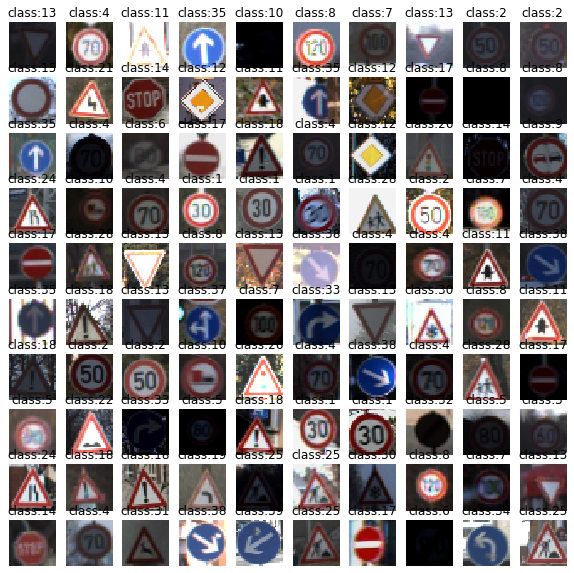

In [59]:
# Helper function for displaying images
def show_batch(image_batch, label_batch, nrows=10, ncols=10):
  plt.figure(figsize=(10,10))
  for n in range(nrows*ncols):
      ax = plt.subplot(nrows, ncols, n+1)
      if no_channels == 3:
        plt.imshow(image_batch[n])
      else:
        plt.imshow(image_batch[n].reshape([img_height_crop, img_width_crop]))
      plt.title('class:' + str(label_batch[n]))
      plt.axis('off')
# Make training dataset to retrieve some images
train_ds = prepare_for_training(labeled_ds_train)

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Visualize images and labels
show_batch(image_batch.numpy(), label_batch.numpy())

Define a neural network model:

In [71]:
# Function for obtaining a CNN model.
def get_model(sd_init):
    
    # Define model.
    inputs = tf.keras.Input(shape=(img_width_crop, img_height_crop, no_channels), name="input")
    x = tf.keras.layers.Conv2D(32, (5, 5), activation=None, 
                                     bias_initializer=tf.initializers.TruncatedNormal(
                                         mean=sd_init, stddev=sd_init), name="conv2d1")(inputs)
    x = tf.keras.layers.ELU(name="elu1")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), name="maxpool2d1")(x)
    x = tf.keras.layers.Conv2D(64, (5, 5), activation=None,
                               bias_initializer=tf.initializers.TruncatedNormal(
                                   mean=sd_init, stddev=sd_init), name="conv2d2")(x)
    x = tf.keras.layers.ELU(name="elu2")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), name="maxpool2d2")(x)
    x = tf.keras.layers.Flatten(name="flatten1")(x)
    outputs = tf.keras.layers.Dense(no_classes, activation='softmax', name="dense1")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="model")
    
    # Model summary.
    model.summary()
    
    # Define optimizer and compile the model.
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Create dictionary for storing model and training information

In [75]:
# First check if dictionary is present - if it isn't, create empty dictionary.
try:
    dict_data
except:
    dict_data = {}

Do the learning:

In [73]:
sd_init = 0.01  # Standard deviation and offset for initializing bias parameters in hidden layers
epochs = 800
run_number = 6

# Get model.
modelTrain = get_model(sd_init=sd_init)

# Fit model.
history = modelTrain.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch)

# Evaluate the model.
eval_train_ds = prepare_for_evaluation(labeled_ds_train)
eval_test_ds = prepare_for_evaluation(labeled_ds_test)
train_results = modelTrain.evaluate(eval_train_ds)
test_results = modelTrain.evaluate(eval_test_ds)
print('Train loss, train acc:', train_results)
print('Test loss, test acc:', test_results)

# Add results to dictionary.
dict_data["Run_" + str(run_number)] = (train_results, test_results, history, modelTrain.to_json())
print("\nAdded to dictionary!")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d1 (Conv2D)             (None, 24, 24, 32)        2432      
_________________________________________________________________
elu1 (ELU)                   (None, 24, 24, 32)        0         
_________________________________________________________________
maxpool2d1 (MaxPooling2D)    (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d2 (Conv2D)             (None, 8, 8, 64)          51264     
_________________________________________________________________
elu2 (ELU)                   (None, 8, 8, 64)          0         
_________________________________________________________________
maxpool2d2 (MaxPooling2D)    (None, 4, 4, 64)          0     

After multiple runs (i.e. 6), save **dict_data** in the pickle format:

In [76]:
# Make copy of dict_data first (have to pull out the .history data first though).
dict_data_2 = {}

for run in dict_data:
    dict_data_2[run] = []
    for entry in dict_data[run]:
        if str(type(entry)) == "<class 'tensorflow.python.keras.callbacks.History'>":
            dict_data_2[run].append(entry.history)
        else:
            dict_data_2[run].append(entry)

model_name = "original_not-improved"
file = open(".\\Models\\" + model_name + ".pkl", 'wb')
pickle.dump(dict_data_2, file)
file.close()
print("Saving done!")

Saving done!


In [77]:
# Make a file copy of the actual model.
modelTrain.save(".\\Models\\" + model_name + ".model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: .\Models\original_not-improved.model\assets


If necessary, reload saved pickle format containing info about model.

In [78]:
load_pickled_model = True
pickle_file = model_name + ".pkl"

if load_pickled_model:
    file = open(".\\Models\\" + pickle_file, "rb")
    new_dict = pickle.load(file)
    file.close()
else:
    new_dict = dict_data_2

There are lot of ways to improve the model above. According to Stallkamp et al. (2012), an ensemble of CNNs can reach 99.46%. Good human performance is 
99.22%.

Below, a plot is created that shows the model accuracy as a result of the number if epochs.

**Further important info about the model:** 
* Epochs: 800
* Number of times to repeat training and testing of a model: 6

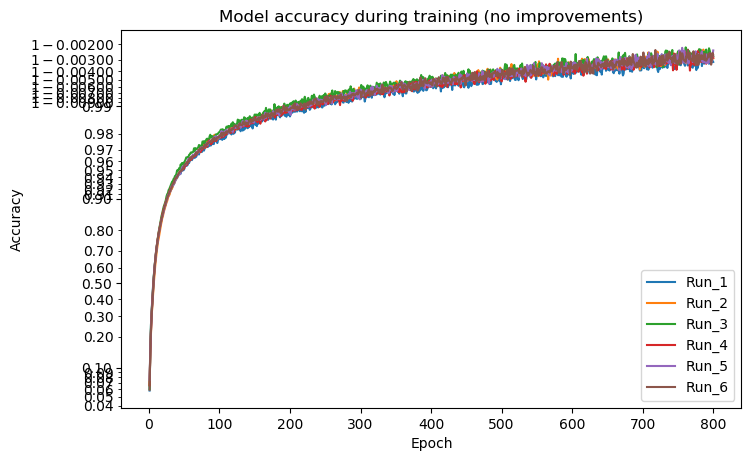

In [81]:
# Plot model accuracy values during training.
plt.figure(figsize=(8, 5), dpi=100)
for run in new_dict.keys():
    plt.plot(range(1, epochs+1), new_dict[run][2]["accuracy"])
plt.title("Model accuracy during training (no improvements)")
plt.yscale("logit")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(new_dict.keys(), loc="best")
plt.show()

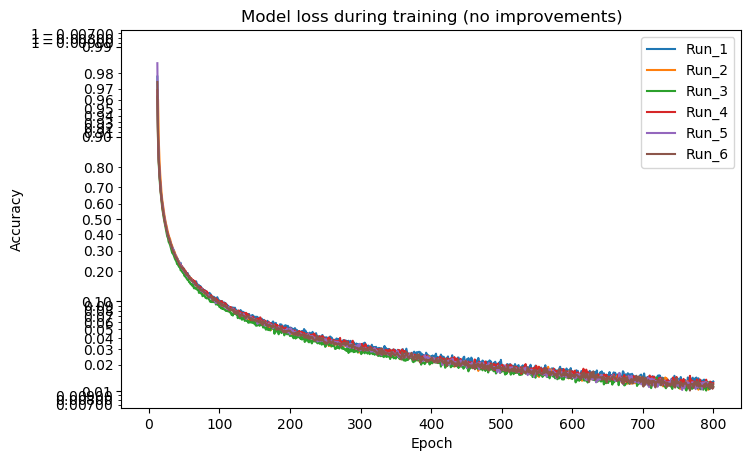

In [82]:
# Plot training loss values.
plt.figure(figsize=(8, 5), dpi=100)
for run in new_dict.keys():
    plt.plot(range(1, epochs+1), new_dict[run][2]["loss"])
plt.title("Model loss during training (no improvements)")
plt.yscale("logit")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(new_dict.keys(), loc="best")
plt.show()

In [83]:
new_dict.keys()

dict_keys(['Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6'])